In [6]:
%matplotlib inline
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

# 8 The Lapped Bi-orthogonal Transform (LBT)

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [7]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [8]:
from cued_sf2_lab.lbt import pot_ii

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

7.531752999057062e-13


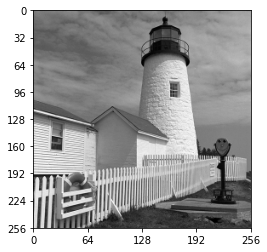

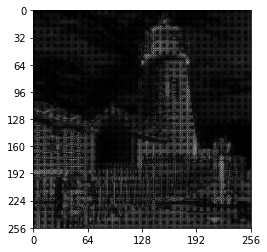

In [22]:
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.dct import regroup

# your code here
N = 8

Pf, Pr = pot_ii(N)
C8 = dct_ii(8)

# pre-filter
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

# dct
Y = colxfm(colxfm(Xp, C8).T, C8).T
Yr = regroup(Y, N)/N

# inverse dct
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

# post-filter
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)

fig, ax = plt.subplots()
plot_image(Zp, ax=ax);

# maximum absolute pixel difference
diff = np.absolute(X-Zp)
max_diff = np.amax(diff)
print(max_diff)

fig, ax = plt.subplots()
plot_image(diff, ax=ax)


## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

In [10]:
# your code here
import math

# find optimum quantisation step

og_rms_error = np.std(X-quantise(X,17))

s = math.sqrt(2)
N = 8

def get_rms_error(s, step): 

    Pf, Pr = pot_ii(N, s)

    C8 = dct_ii(8)

    # pre-filter
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

    # dct
    Y = colxfm(colxfm(Xp, C8).T, C8).T
    Yq = quantise(Y, step)
#     Yr = regroup(Yq, N)/N

    # inverse dct
    Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)

    # post-filter
    Zp = Z.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)

    # find final rms error
    return np.std (X-Zp)

def find_optimum_step(s): 
    step_sizes = np.linspace(20,27,300)
    for step in step_sizes: 
        if og_rms_error-get_rms_error(s, step) < 0: 
            return step

s_arr = np.linspace(1,2,50)
optimum_steps = []
for s in s_arr: 
    optimum_steps.append(find_optimum_step(s))

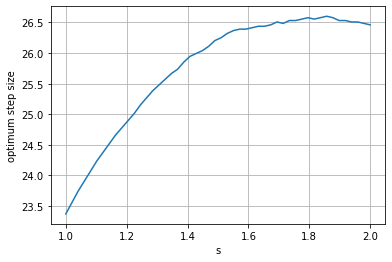

In [11]:
fig, ax = plt.subplots()
plt.plot(s_arr, optimum_steps) 
plt.xlabel('s')
plt.ylabel('optimum step size')
plt.grid()
plt.show()

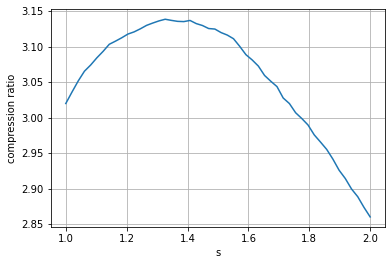

1.3265306122448979


In [12]:
# find s that maximises the compression ratios

# optimum_steps
# s_arr

def dctbpp(Yr, N): 
    # Your code here
    entropies = np.zeros((N,N))
    
    # width of subimage: 
    w = int(np.shape(Yr)[0]/N) # = 32
    
    for i in range(N): 
        for j in range(N): 

            Ys = np.zeros((w,w)) # subimage
            for row in range(w): 
                for col in range(w):
                    Ys[row,col]=Yr[i*w+row,j*w+col]

            entropies[i,j] = bpp(Ys) 
    
    bits = entropies * (w**2.0)
    
    total_bits = np.sum(bits)
    return total_bits

# find compression ratio for each s
crs = []

def calculate_bits(X): 
    entropy = bpp(X)
    bits = np.shape(X)[0]*np.shape(X)[1]*entropy
    return bits

bits_ref = calculate_bits(quantise(X,17))


N=8
for i in range(len(s_arr)): 
    s = s_arr[i]
    step = optimum_steps[i]
    
    Pf, Pr = pot_ii(N, s)

    C8 = dct_ii(N)

    # pre-filter
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

    # dct
    Y = colxfm(colxfm(Xp, C8).T, C8).T
    Yq = quantise(Y, step)
    Yr = regroup(Yq, N)/N
    bits_comp = dctbpp(Yr, N)
    
    cr = bits_ref/bits_comp
    
    crs.append(cr)
    
fig, ax = plt.subplots()
plt.plot(s_arr, crs) 
plt.xlabel('s')
plt.ylabel('compression ratio')

plt.grid()
plt.show()

# optimum s is
opt_s = s_arr[crs.index(np.max(crs))]
print(opt_s)

157663.99327305343


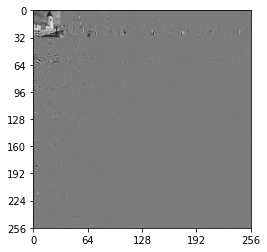

In [26]:

# your code here
N = 8

Pf, Pr = pot_ii(N)
C8 = dct_ii(8)

# pre-filter
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

# dct
Y = colxfm(colxfm(Xp, C8).T, C8).T
Yr = regroup(Y, N)/N

# inverse dct
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

# post-filter
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)

# fig, ax = plt.subplots()
# plot_image(Zp, ax=ax);

# # maximum absolute pixel difference
# diff = np.absolute(X-Zp)
# max_diff = np.amax(diff)
# print(max_diff)

fig, ax = plt.subplots()
plot_image(Yr, ax=ax)
print(dctbpp(Yr, 16))


The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

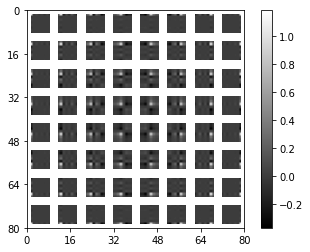

In [13]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

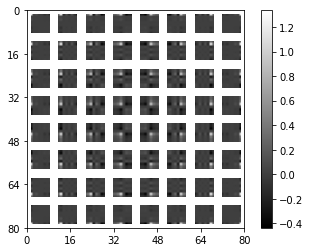

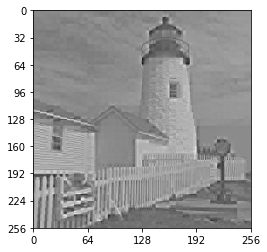

In [14]:
# your code here

s = 2
N=8
# bases
Pf, Pr = pot_ii(8, s)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

# pre-filter
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

fig, ax = plt.subplots()
plot_image(Xp, ax=ax);


With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

In [15]:
# first find the optimum step for the different N

def get_rms_error(N, s, step): 

    Pf, Pr = pot_ii(N, s)

    CN = dct_ii(N)

    # pre-filter
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

    # dct
    Y = colxfm(colxfm(Xp, CN).T, CN).T
    Yq = quantise(Y, step)
#     Yr = regroup(Yq, N)/N

    # inverse dct
    Z = colxfm(colxfm(Yq.T, CN.T).T, CN.T)

    # post-filter
    Zp = Z.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)

    # find final rms error
    return np.std (X-Zp)

def find_optimum_step(N, s): 
    step_sizes = np.linspace(17,30,900)
    for step in step_sizes: 
        if og_rms_error-get_rms_error(N, s, step) < 0: 
            return step
        
s = opt_s
print('optimum step for 4x4 block:', find_optimum_step(4, s))
print('optimum step for 8x8 block:', find_optimum_step(8, s))
print('optimum step for 16x16 block:', find_optimum_step(16, s))


optimum step for 4x4 block: 28.091212458286986
optimum step for 8x8 block: 25.560622914349274
optimum step for 16x16 block: 22.813125695216907


In [20]:
# always use dctbpp(Yr, 16) now to calculate the total number of bits
# use the step value that matches the rms error

# find compression ratio
# visualise the image

def calculate_bits(X): 
    entropy = bpp(X)
    bits = np.shape(X)[0]*np.shape(X)[1]*entropy
    return bits

def calculate_cr(N, s, step): 
    Pf, Pr = pot_ii(N, s)
    CN = dct_ii(N)

    # pre-filter
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Xp = X.copy()  # copy the non-transformed edges directly from X
    Xp[t,:] = colxfm(Xp[t,:], Pf)
    Xp[:,t] = colxfm(Xp[:,t].T, Pf).T

    # dct
    Y = colxfm(colxfm(Xp, CN).T, CN).T
    Yq = quantise(Y, step)
    Yr = regroup(Yq, N)/N

#     print(Yr)
#     fig, ax = plt.subplots()
#     plot_image(Yr, ax=ax);
    
    bits_ref = calculate_bits(quantise(X,17))
    bits_comp = dctbpp(Yr, 16)
    print(bits_ref, bits_comp)
    
    cr = bits_ref/bits_comp
    
    # visualise the image
    # inverse dct
    Z = colxfm(colxfm(Yq.T, CN.T).T, CN.T)

    # post-filter
    Zp = Z.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)
    
    return cr

s = opt_s # choose this
print('Compression ratio for 4x4 block:', calculate_cr(4, s, 28.872080088987765))
print('Compression ratio for 8x8 block:', calculate_cr(8, s, 25.951056729699665))
print('Compression ratio for 16x16 block:', calculate_cr(16, s, 22.943270300333705))


228119.03651868744 62834.56521424101
Compression ratio for 4x4 block: 3.630470517952846
228119.03651868744 65792.8129612657
Compression ratio for 8x8 block: 3.4672333686809877
228119.03651868744 76993.49116404644
Compression ratio for 16x16 block: 2.9628353393229676
